# Problem Solving with Python
## Final Project
### Oliver Brown - 2103101





This is the Jupyter Notebook that corresponds to my final project for the module. We are investigating the following problem:

> Problem 1: Particle collision.
There are many subatomic particles trapped in a box. They can collide with one
another but cannot escape from the box.
The particles come in 3 species, call them A, B and C.
When two particles of different species collide, they both change into the third remaining
species. For example, when A collides with B, they both change into C.
Investigate.

We will now model this scenario in 2d, having developed the neccessary theory in the written pdf that corresponds to this notebook.

First, we'll import all the neccessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations

Define number of particles and get random positions (between 0 and 1) for each particle

# Pairwise Distance Between Particles

To work out if two particles have collided, we should find the distance between *all* pairs of particles and then see if any of those distances are below the needed threshold for collision. The threshold is $2r$ where $r$ is the radius of each particle. We have $n$ particles so by basic combinatorics, we have $\frac{n(n-1)}{2}$ pairs. We can enumerate these pairs using `combinations`. The toy example below demonstrates what's going on.


In [3]:
n_particles = 10
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))

`ids_pairs` list all the combinations of particles

In [4]:
ids_pairs

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 8],
       [0, 9],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [1, 8],
       [1, 9],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [2, 7],
       [2, 8],
       [2, 9],
       [3, 4],
       [3, 5],
       [3, 6],
       [3, 7],
       [3, 8],
       [3, 9],
       [4, 5],
       [4, 6],
       [4, 7],
       [4, 8],
       [4, 9],
       [5, 6],
       [5, 7],
       [5, 8],
       [5, 9],
       [6, 7],
       [6, 8],
       [6, 9],
       [7, 8],
       [7, 9],
       [8, 9]])

We can generate starting positions for each of our particles. The vector $x\in\mathbb{R}^{2\times n}$ contains the $x$ and $y$ positions of each of the $n$ particles, i.e particle $i$ has position vector $x_i=(x_i,y_i)$.  

In [5]:
x = np.random.random((2,n_particles))
print(x)

[[0.53745199 0.74912554 0.03967607 0.20335777 0.64431073 0.45229795
  0.51739909 0.51157958 0.35632797 0.82695591]
 [0.45462993 0.33852416 0.43147042 0.1719907  0.08650444 0.81749433
  0.37270061 0.51425602 0.74714996 0.98884273]]


We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles, $(x_i,x_j)$

In [6]:
x_pairs = np.array([x[0][ids_pairs[:,0]], x[0][ids_pairs[:,1]]]).T
x_pairs

array([[0.53745199, 0.74912554],
       [0.53745199, 0.03967607],
       [0.53745199, 0.20335777],
       [0.53745199, 0.64431073],
       [0.53745199, 0.45229795],
       [0.53745199, 0.51739909],
       [0.53745199, 0.51157958],
       [0.53745199, 0.35632797],
       [0.53745199, 0.82695591],
       [0.74912554, 0.03967607],
       [0.74912554, 0.20335777],
       [0.74912554, 0.64431073],
       [0.74912554, 0.45229795],
       [0.74912554, 0.51739909],
       [0.74912554, 0.51157958],
       [0.74912554, 0.35632797],
       [0.74912554, 0.82695591],
       [0.03967607, 0.20335777],
       [0.03967607, 0.64431073],
       [0.03967607, 0.45229795],
       [0.03967607, 0.51739909],
       [0.03967607, 0.51157958],
       [0.03967607, 0.35632797],
       [0.03967607, 0.82695591],
       [0.20335777, 0.64431073],
       [0.20335777, 0.45229795],
       [0.20335777, 0.51739909],
       [0.20335777, 0.51157958],
       [0.20335777, 0.35632797],
       [0.20335777, 0.82695591],
       [0.

* Then take the difference, $x_i-x_j$ to get $\Delta x_{ij}$ of all pairs

In [7]:
dx_pairs = np.diff(x_pairs, axis=1).ravel()
dx_pairs

array([ 0.21167354, -0.49777592, -0.33409423,  0.10685874, -0.08515404,
       -0.0200529 , -0.02587241, -0.18112402,  0.28950391, -0.70944947,
       -0.54576777, -0.1048148 , -0.29682758, -0.23172645, -0.23754596,
       -0.39279757,  0.07783037,  0.1636817 ,  0.60463466,  0.41262188,
        0.47772302,  0.47190351,  0.3166519 ,  0.78727984,  0.44095297,
        0.24894019,  0.31404132,  0.30822181,  0.1529702 ,  0.62359814,
       -0.19201278, -0.12691164, -0.13273115, -0.28798276,  0.18264517,
        0.06510114,  0.05928163, -0.09596998,  0.37465795, -0.00581951,
       -0.16107112,  0.30955682, -0.15525161,  0.31537633,  0.47062794])

The total distance between each pair is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$.

In [8]:
x_pairs = np.array([x[0][ids_pairs[:,0]], x[0][ids_pairs[:,1]]]).T
y_pairs = np.array([x[1][ids_pairs[:,0]], x[1][ids_pairs[:,1]]]).T
dx_pairs = np.diff(x_pairs, axis=1).ravel()
dy_pairs = np.diff(y_pairs, axis=1).ravel()
d_pairs = np.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

array([0.24142543, 0.49831439, 0.43761157, 0.38332123, 0.37272212,
       0.08434769, 0.06499732, 0.34405505, 0.60761486, 0.71551209,
       0.57061007, 0.27294703, 0.56348828, 0.23423317, 0.29548227,
       0.56680242, 0.65495939, 0.30679215, 0.69612111, 0.56504095,
       0.48132439, 0.47910998, 0.44712638, 0.9646105 , 0.44916302,
       0.69184258, 0.37270152, 0.46059336, 0.59515382, 1.02767791,
       0.75578775, 0.31307317, 0.4478716 , 0.7206848 , 0.92063762,
       0.44953266, 0.30897861, 0.11898978, 0.41198162, 0.14167498,
       0.40762265, 0.68953356, 0.27989757, 0.56981994, 0.52906148])

We can also initalise some kind of starting velocity. For ease, let's pick a gaussian distribution. How about $v_i \sim \mathcal{N}(0,500^2)$

In [9]:
v = np.random.normal(0,500,size=(2,n_particles))
v

array([[ -323.81562598, -1198.22156866,  -411.34419292,   173.86909042,
           44.69191558,   -81.9553934 ,   723.51747626,   -58.24611857,
         -622.0881419 ,   561.16976203],
       [  341.58396972,  -233.26157304,  -653.53997472,   315.00951095,
          919.25992756,   -79.7582313 ,    -4.77191823,  -739.26731389,
          888.45525681,  -375.39676809]])

# Calculating Velocities After Collision

So in each frame of our simulation, we will calculate `d_pairs`. If $d_{ij}<2r$, for any $(i,j)\in\{1,\dots,n\}^2$, then we will need to calculate the particles new velocities because a collision has occured. We have access to the positions $x_A$ and $x_B$ and the velocities $u_A$ and $u_B$ of the particle before the collision.

The derivation in my written pdf yields the formulae

$$v_A = u_A-\frac{(u_A-u_B)\cdot(x_A-x_B)}{|x_A-x_B|}(x_A-x_B)$$
$$v_B = u_B-\frac{(u_B-u_A)\cdot(x_B-x_A)}{|x_B-x_A|}(x_B-x_A)$$

We can now implement these in code

In [10]:
# checking the condition d_ij < 2r gives us the particles that collide
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

array([[0, 6],
       [0, 7],
       [5, 8]])

We will call all the particles in the left column "1" and the right column "2"

In [11]:
u1 = v[:,ids_pairs_collide[:,0]]
u2 = v[:,ids_pairs_collide[:,1]]
x1 = x[:,ids_pairs_collide[:,0]]
x2 = x[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [12]:
v1new = u1 - ((u1-u2)*(x1-x2)).sum(axis=0)/np.sum((x1-x2)**2, axis=0) * (x1-x2)
v2new = u2 - ((u1-u2)*(x1-x2)).sum(axis=0)/np.sum((x2-x1)**2, axis=0) * (x2-x1)

# Building Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier. We won't factor in the different species types just yet as we need to check a standard simulation works first.

In [13]:
def get_delta_pairs(x, ids_pairs):
    return np.diff(np.array([x[ids_pairs[:,0]], x[ids_pairs[:,1]]]).T, axis=1).ravel()

def get_deltad_pairs(x, ids_pairs):
    return np.sqrt(get_delta_pairs(x[0], ids_pairs)**2 + get_delta_pairs(x[1], ids_pairs)**2)

def compute_new_v(u1, u2, x1, x2):
    v1 = u1 - ((u1-u2)*(x1-x2)).sum(axis=0)/np.sum((x1-x2)**2, axis=0) * (x1-x2)
    v2 = u2 - ((u1-u2)*(x1-x2)).sum(axis=0)/np.sum((x2-x1)**2, axis=0) * (x2-x1)
    return v1, v2

def motion(x, v, id_pairs, ts, dt, d_cutoff):
    xs = np.zeros((ts, x.shape[0], x.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    xs[0] = x.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        # particle collisions
        ic = id_pairs[get_deltad_pairs(x, ids_pairs) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], x[:,ic[:,0]], x[:,ic[:,1]])

        # wall collisions
        v[0,x[0]>1] = -np.abs(v[0,x[0]>1])
        v[0,x[0]<0] = np.abs(v[0,x[0]<0])
        v[1,x[1]>1] = -np.abs(v[1,x[1]>1])
        v[1,x[1]<0] = np.abs(v[1,x[1]<0])

        # position updates
        x = x + v*dt
        xs[i] = x.copy()
        vs[i] = v.copy()
    return xs, vs

Set the radius and find the position of all particles as a function of time (3D array `xs` where each axis is $(t,x,y)$).

In [14]:
radius = 0.03
xs, vs = motion(x, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size, adding some arbitrary labels to the particles

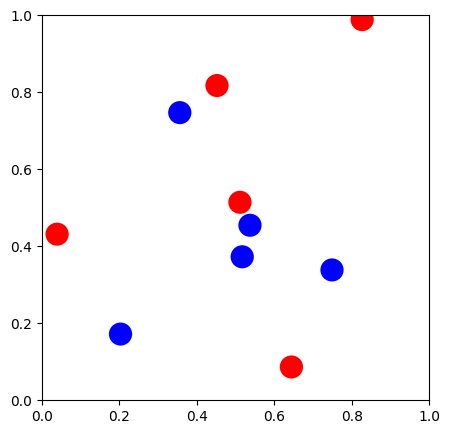

In [15]:
# labeling particles red and blue with equal probability
c = np.random.choice([0,1],p=[1/2,1/2],size=n_particles)

# plotting the first frame
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = xs[0][0][c==0], xs[0][1][c==0]
xblue, yblue = xs[0][0][c==1],xs[0][1][c==1]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

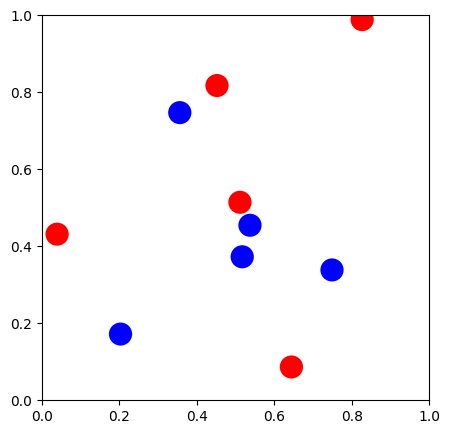

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred = xs[i][0][c==0], xs[i][1][c==0]
    xblue, yblue = xs[i][0][c==1],xs[i][1][c==1]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani1.gif',writer='pillow',fps=30,dpi=100)

It works! We can now build up this model to add another colour and make the unlike particles change colour on collision.

# Adding Particle Species

Let's get these all running in one code block. We can add a histogram alongside our simulation so we can keep track of how much of each species exists.

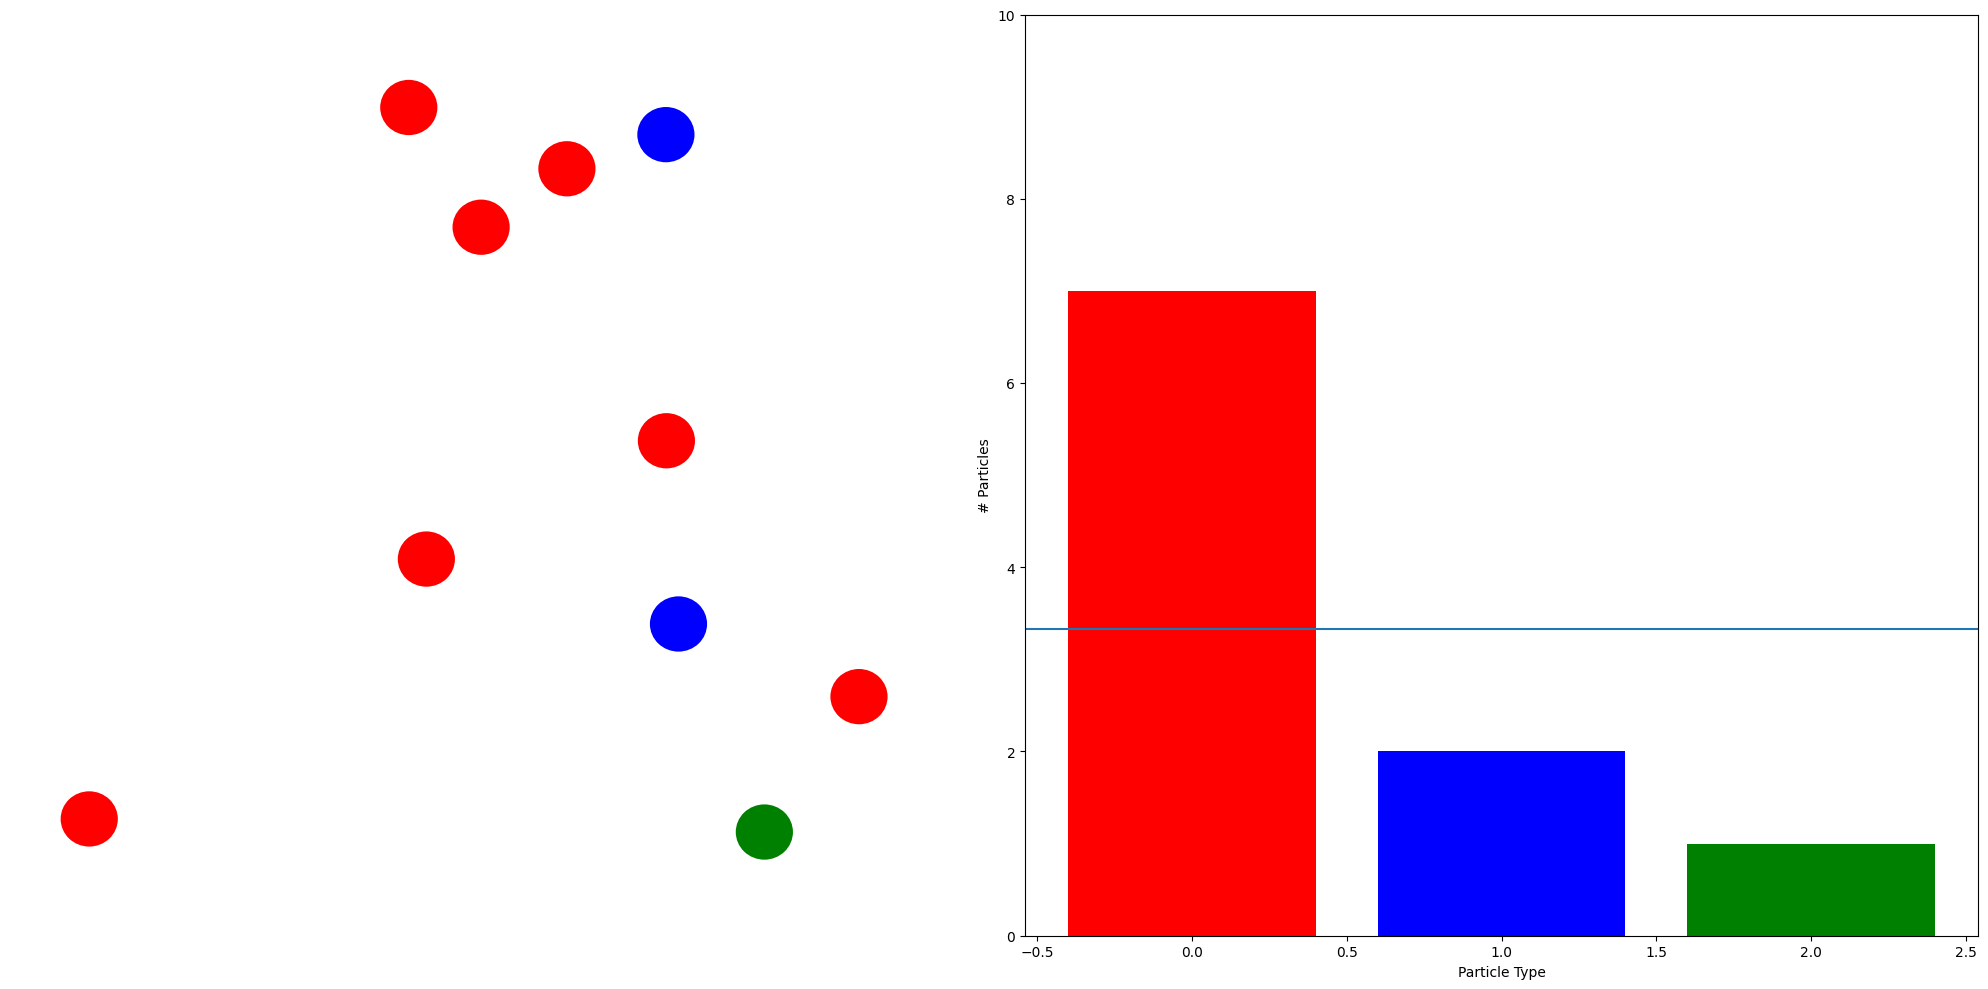

In [17]:
# overall simulation data
n_particles = 10
ts=500

# initalising particle data including a colour matrix to keep a record
# of the colour of each particle at each timestep
x = np.random.random((2,n_particles))
c = np.random.choice([0,1,2],n_particles,p=[1/3,1/3,1/3])
v = np.random.normal(0,500,size=(2,n_particles))
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))

# rules for how particles convert from one species to another
def truth_table(p1,p2):
    if p1 == p2:
        return p1
    elif (p1 == 1 and p2 == 0) or (p1 == 0 and p2 == 1):
        return 2
    elif (p1 == 2 and p2 == 0) or (p1 == 0 and p2 == 2):
        return 1
    else:
        return 0

def compute_new_c(c1,c2):
    c_new = [truth_table(p1,p2) for p1,p2 in zip(c1,c2)]
    return c_new, c_new

# updated motion function now including particle transfer
def motion(x, v, id_pairs, ts, dt, d_cutoff):
    xs = np.zeros((ts, x.shape[0], x.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    cs = np.zeros((ts,c.shape[0]))
    # Initial State
    xs[0] = x.copy()
    vs[0] = v.copy()
    cs[0] = c.copy()
    for i in range(1,ts):

        # which particles collide
        ic = id_pairs[get_deltad_pairs(x, ids_pairs) < d_cutoff]

        # change velocities after collision
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], x[:,ic[:,0]], x[:,ic[:,1]])

        # change colours after collision
        c[ic[:,0]], c[ic[:,1]] = compute_new_c(c[ic[:,0]], c[ic[:,1]])

        # wall collisions
        v[0,x[0]>1] = -np.abs(v[0,x[0]>1])
        v[0,x[0]<0] = np.abs(v[0,x[0]<0])
        v[1,x[1]>1] = -np.abs(v[1,x[1]>1])
        v[1,x[1]<0] = np.abs(v[1,x[1]<0])

        # particle updates
        x = x + v*dt

        # copying new data to overall simulation arrays
        xs[i] = x.copy()
        vs[i] = v.copy()
        cs[i] = c.copy()
    return xs, vs, cs


# run the simulation
radius = 0.03
xs, vs, cs = motion(x, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

fig, axes = plt.subplots(1, 2, figsize=(20,10))

def animate(i):
    #ax.clear()
    [ax.clear() for ax in axes]

    # first axis with particle simulation
    ax = axes[0]
    xred, yred = xs[i][0][cs[i]==0], xs[i][1][cs[i]==0]
    xblue, yblue = xs[i][0][cs[i]==1],xs[i][1][cs[i]==1]
    xgreen, ygreen = xs[i][0][cs[i]==2],xs[i][1][cs[i]==2]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    circles_green = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xgreen,ygreen)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    cgreen = matplotlib.collections.PatchCollection(circles_green, facecolors='green')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.add_collection(cgreen)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_axis_off()

    # second axis with histogram
    ax = axes[1]
    num, count = np.unique(cs[i], return_counts=True)
    ax.bar(num, count, color = ['red','blue','green'])
    ax.axhline(y=n_particles*1/3)
    ax.set_ylim(ymin=0,ymax=n_particles)
    ax.set_xlabel('Particle Type')
    ax.set_ylabel('# Particles')
    fig.tight_layout()

# animate the simulation
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
#ani.save('ani2.gif',writer='pillow',fps=30,dpi=100)

# Full Simulations to Test Conjecture

Now that we're sure that it works, lets make a simulation containing many more particles. Try all starting red.

Now lets try a less extreme example!

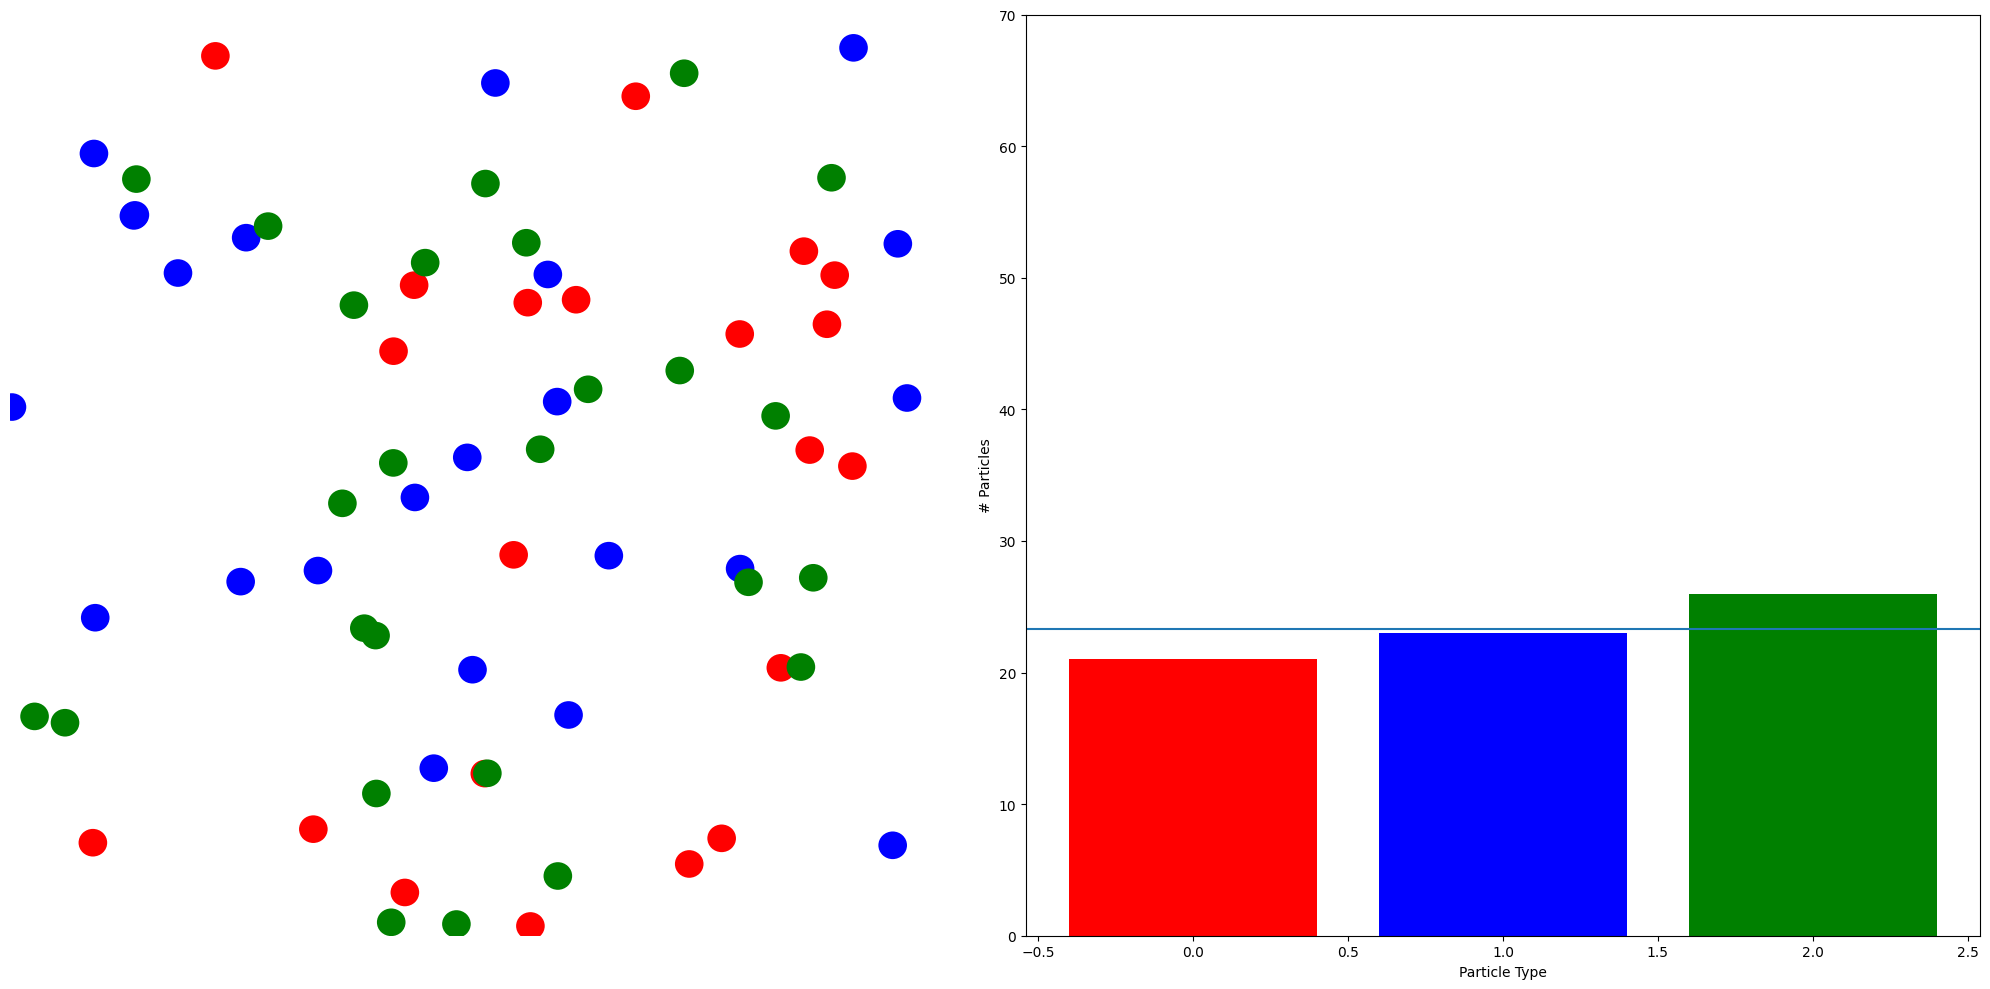

In [18]:
n_particles = 70
ts=2000
x = np.random.random((2,n_particles))
c = np.random.choice([0,1,2],size = n_particles,p=[1/3,1/3,1/3])
v = np.random.normal(30,500,size=(2,n_particles))

ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))
radius = 0.015

xs, vs, cs = motion(x, v, ids_pairs, ts=ts, dt=0.000008, d_cutoff=2*radius)

fig, axes = plt.subplots(1, 2, figsize=(20,10))

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani3.gif',writer='pillow',fps=30,dpi=100)

# Statistical Model

We can see that if $N_k(t)$ counts the number of particles of species $k$ at time $t$, then regardless of non-degenerate inital conditions, we have that

$$\frac{N_k(t)}{N} \approx \frac{1}{3}$$

for $k\in\{A,B,C\}$

Much how much do we vary from this average? By the symetry of the enviroment, we can just focus on species $A$. We could model

$$N_k(t)\sim\text{Binomial}(N,1/3)$$

Does this match our data?


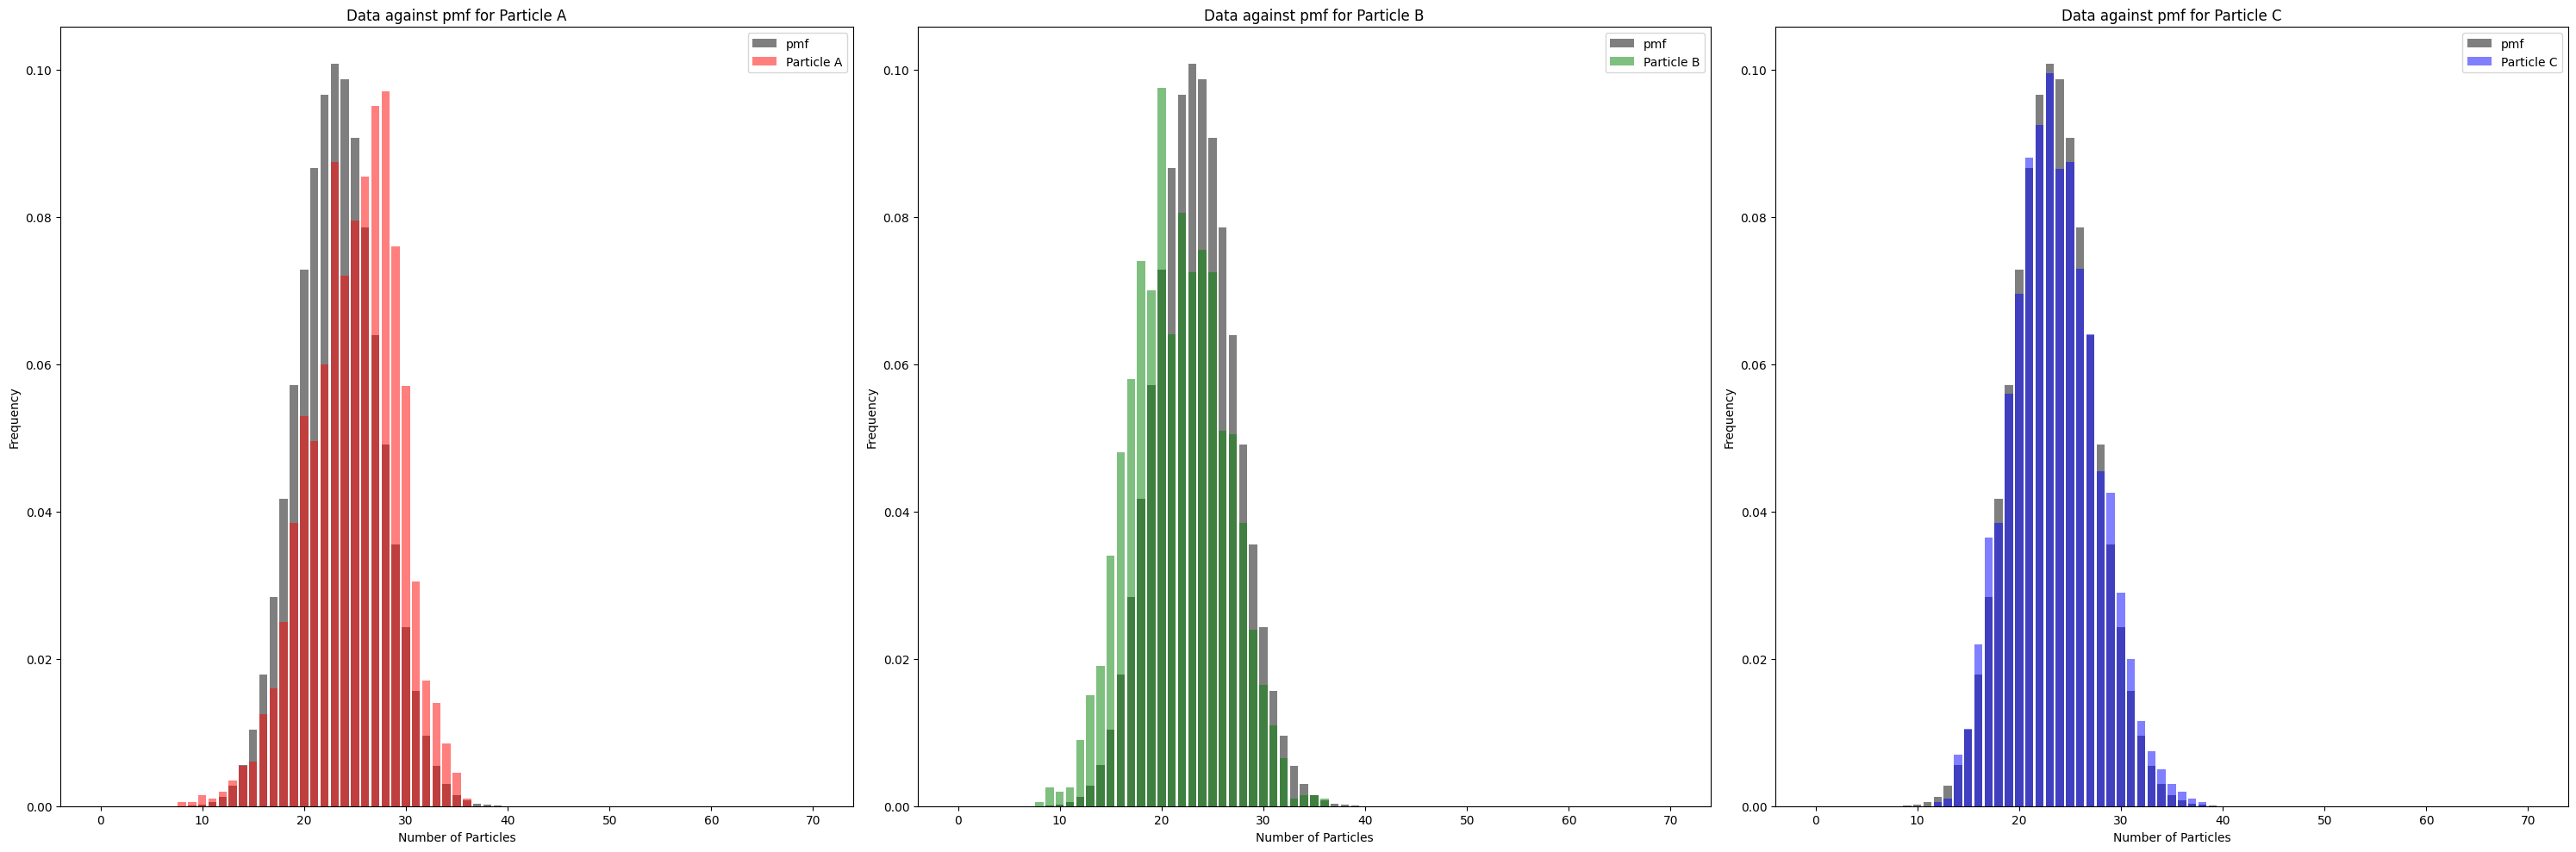

In [19]:
from scipy.stats import binom
from collections import Counter

fig, axes = plt.subplots(1, 3, figsize=(30,10))

# setting the values
# of n and p
n = n_particles
p = 1/3
# defining the range of values we'll consider
r_values = list(range(n + 1))
colour = ['r','g','b']
label = ['Particle A', 'Particle B', 'Particle C']

for k in range(3):

  ax = axes[k]

  ### BINOMIAL MODEL
  dist = [binom.pmf(r, n, p) for r in r_values]
  ax.bar(r_values,dist,label='pmf',alpha=0.5,color='black')

  ### PARTICLE DATA
  N_k_count = Counter([len(cs[i][cs[i]==k]) for i in range(len(cs))])
  N_k = [N_k_count[r]/(ts) for r in r_values]
  ax.bar(r_values,N_k,label=label[k],alpha=0.5,color=colour[k])

  ax.legend()
  ax.set_xlabel('Number of Particles')
  ax.set_ylabel('Frequency')
  ax.set_title('Data against pmf for '+label[k])


fig.tight_layout()
plt.show()

# A more extreme example

How does this hold with a more extreme starting position?

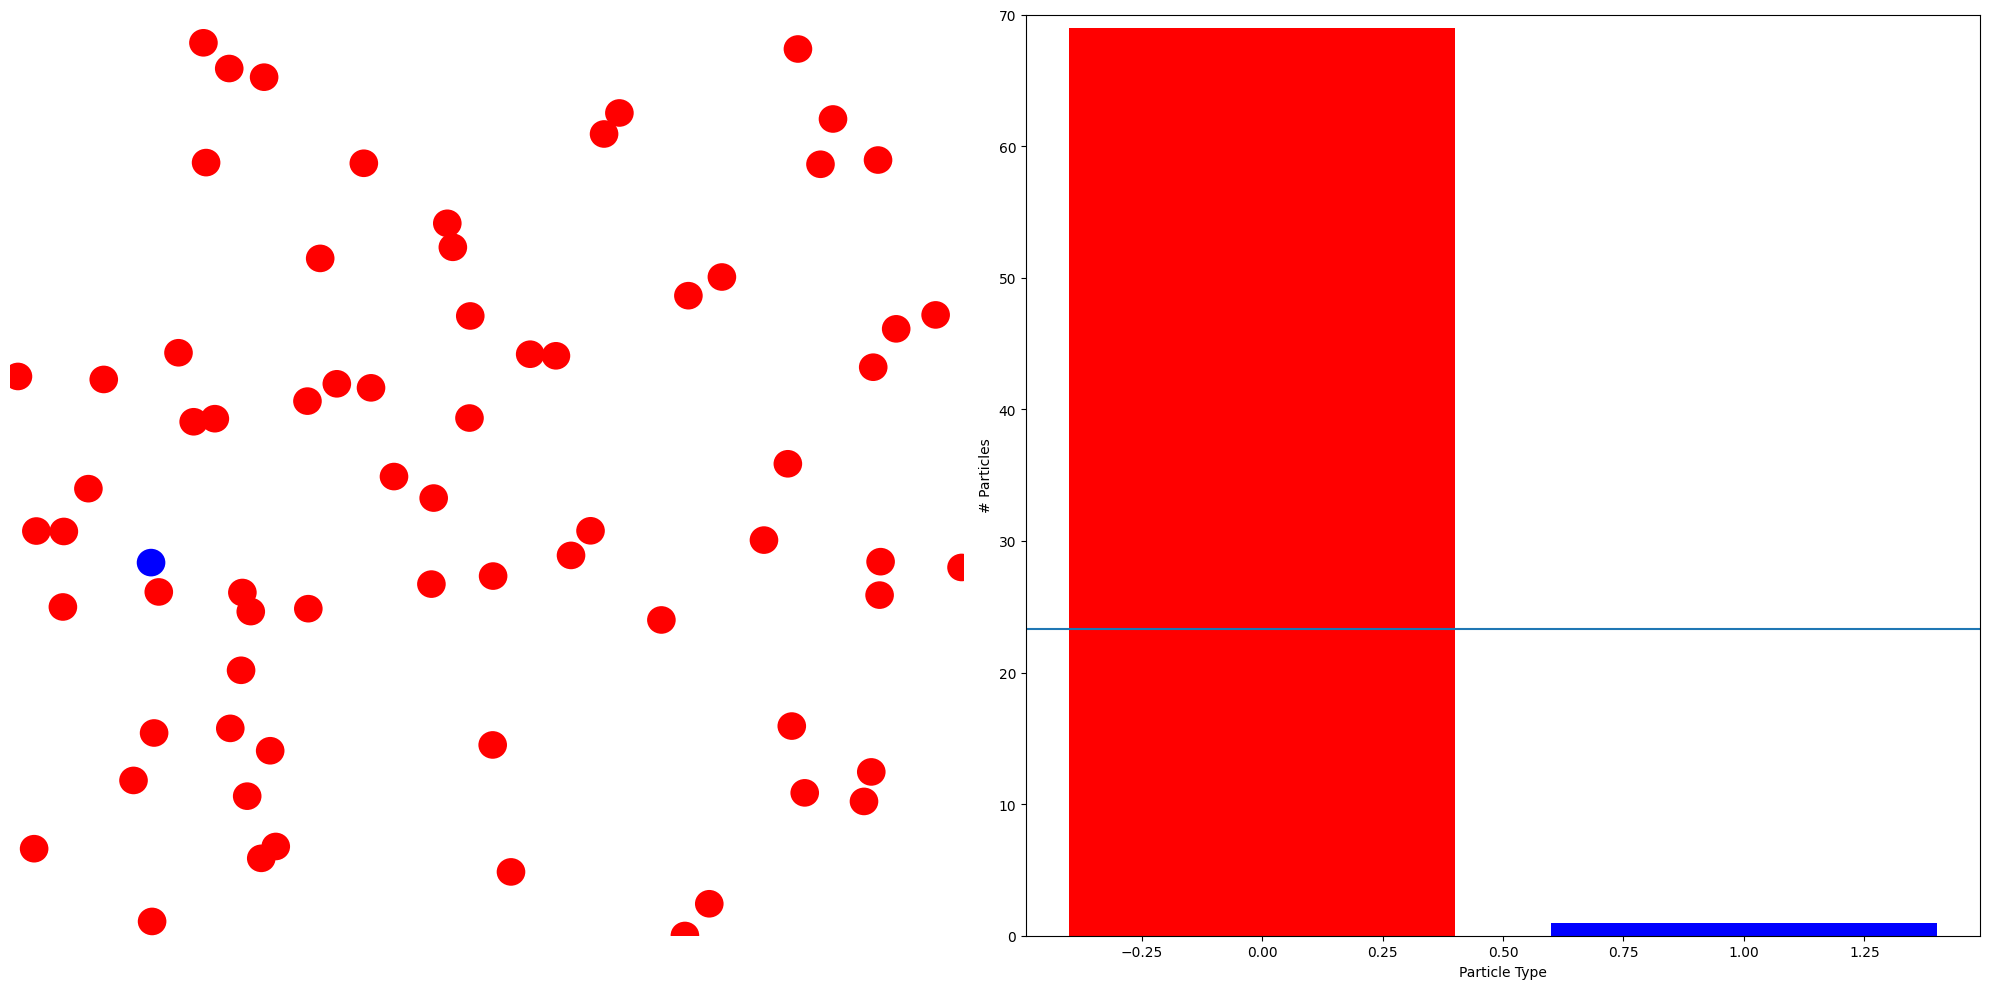

In [20]:
# set the simulation data
n_particles = 70
ts=2000
r = np.random.random((2,n_particles))
c = np.zeros(n_particles) # all particles are colour 0 (red)
c[0] = 1                  # except for one!
v = np.random.normal(0,500,size=(2,n_particles))
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))

radius = 0.015
xs, vs, cs = motion(r, v, ids_pairs, ts=ts, dt=0.000008, d_cutoff=2*radius)


fig, axes = plt.subplots(1, 2, figsize=(20,10))

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani4.gif',writer='pillow',fps=30,dpi=100)

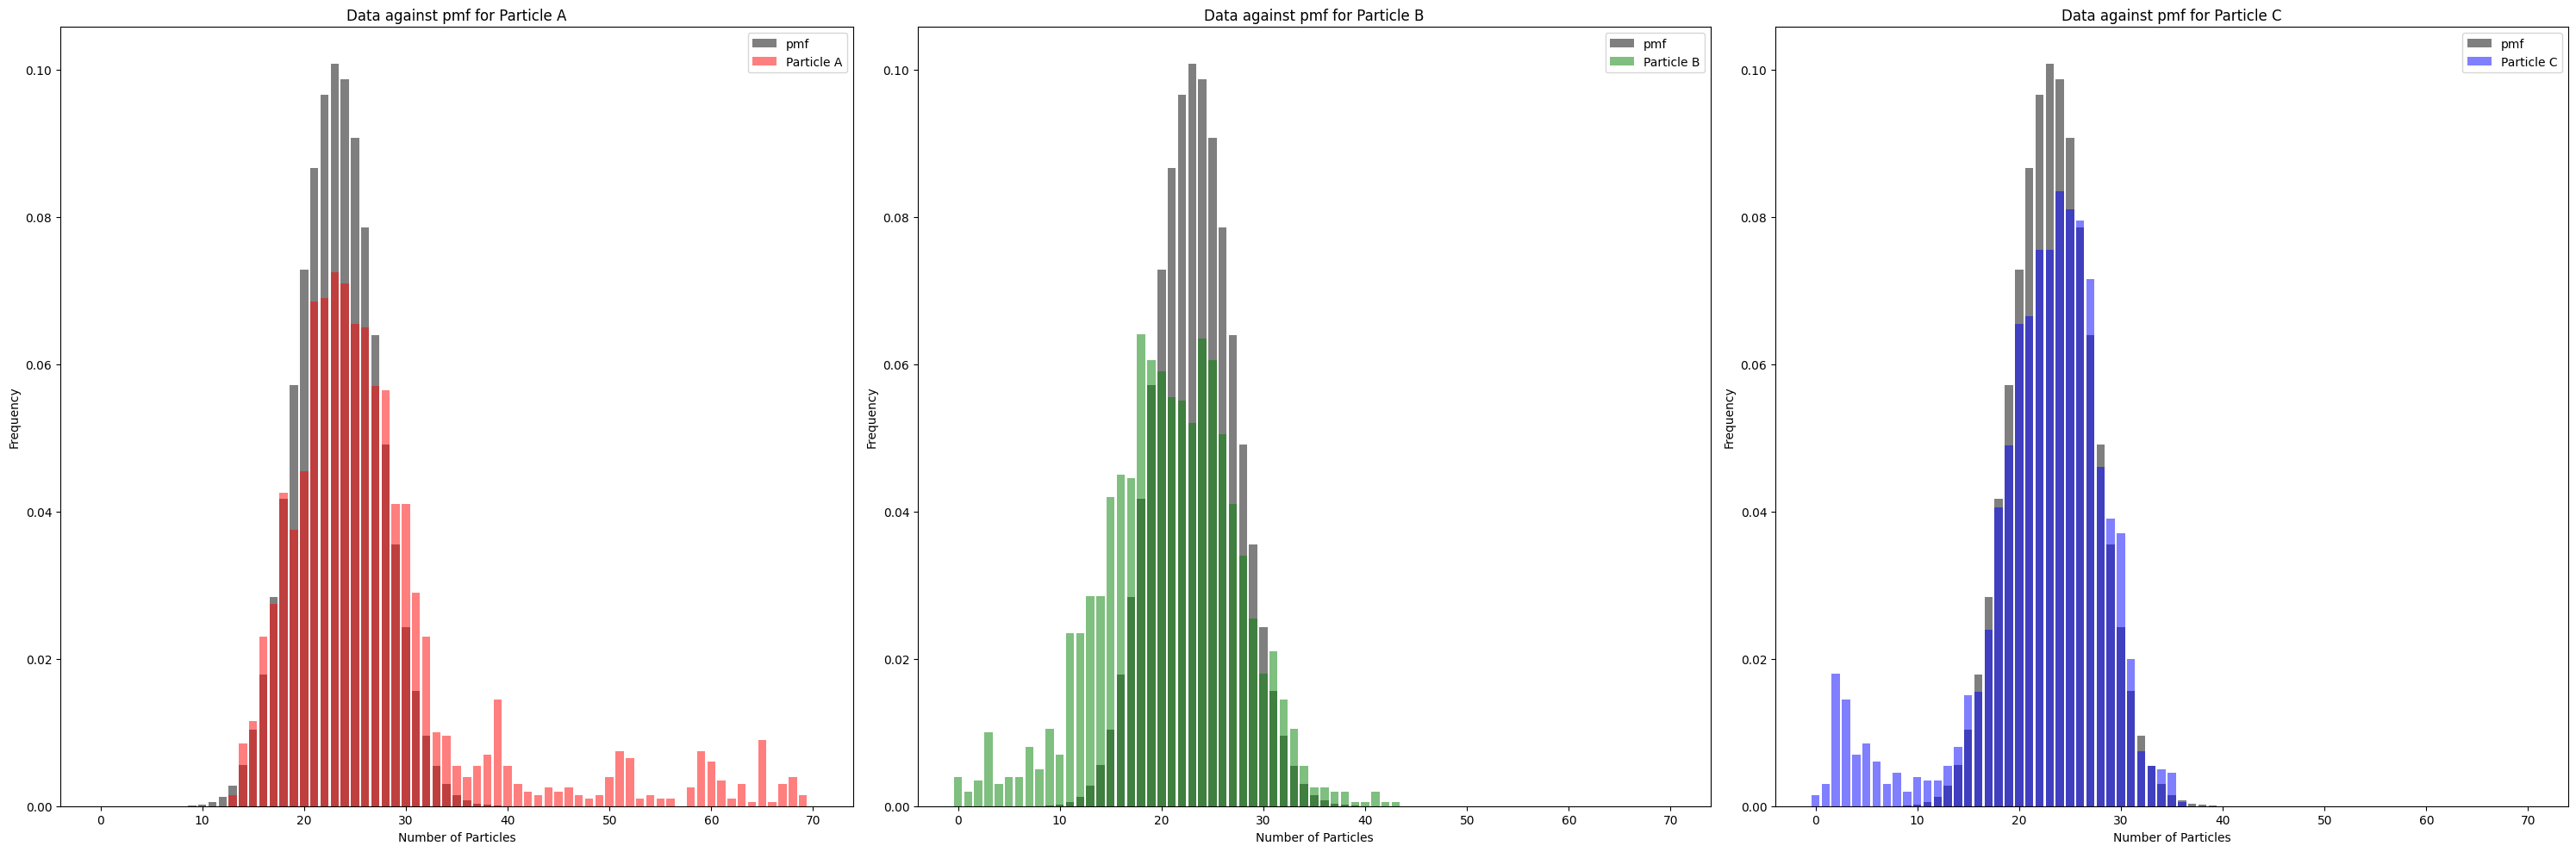

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

# setting the values
# of n and p
n = n_particles
p = 1/3
# defining the range of values we'll consider
r_values = list(range(n_particles + 1))
colour = ['r','g','b']
label = ['Particle A', 'Particle B', 'Particle C']

for k in range(3):

  ax = axes[k]

  ### BINOMIAL MODEL

  # obtaining the mean and variance
  mean, var = binom.stats(n, p)
  # list of pmf values
  dist = [binom.pmf(r, n, p) for r in r_values]
  ax.bar(r_values,dist,label='pmf',alpha=0.5,color='black')

  ### PARTICLE DATA
  N_k_t = [len(cs[i][cs[i]==k]) for i in range(len(cs))]
  N_k_count = Counter(N_k_t)
  N_k = [N_k_count[r]/(ts) for r in r_values]
  ax.bar(r_values,N_k,label=label[k],alpha=0.5,color=colour[k])

  ax.legend()
  ax.set_xlabel('Number of Particles')
  ax.set_ylabel('Frequency')
  ax.set_title('Data against pmf for '+label[k])


fig.tight_layout()
plt.show()

We see that in this extreme case, we'll need to increase the lenght of the simulation before we see good agreement with our model's pmf.

Trying again with more frames...

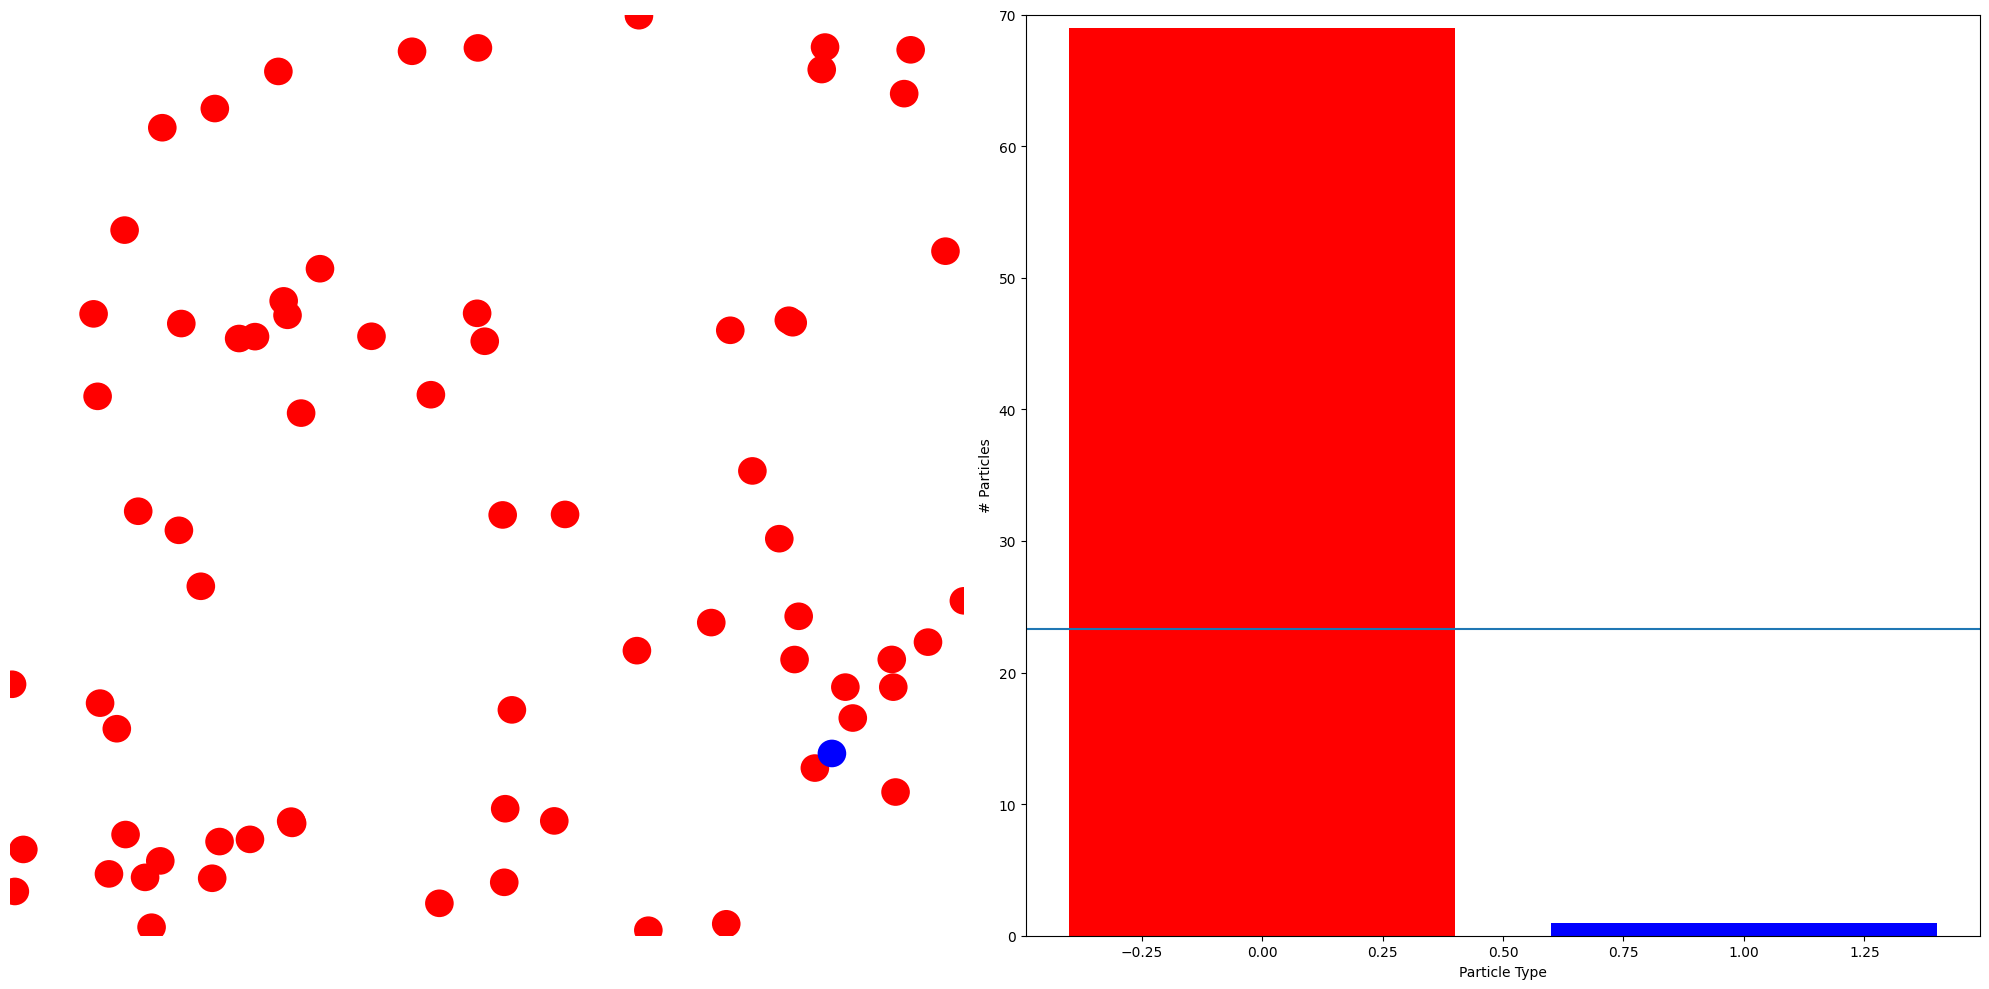

In [22]:
# set the simulation data
n_particles = 70
ts=4000
r = np.random.random((2,n_particles))
c = np.zeros(n_particles) # all particles are colour 0 (red)
c[0] = 1                  # except for one!
v = np.random.normal(0,500,size=(2,n_particles))
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))

radius = 0.015
xs, vs, cs = motion(r, v, ids_pairs, ts=ts, dt=0.000008, d_cutoff=2*radius)


fig, axes = plt.subplots(1, 2, figsize=(20,10))

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani5.gif',writer='pillow',fps=30,dpi=100)

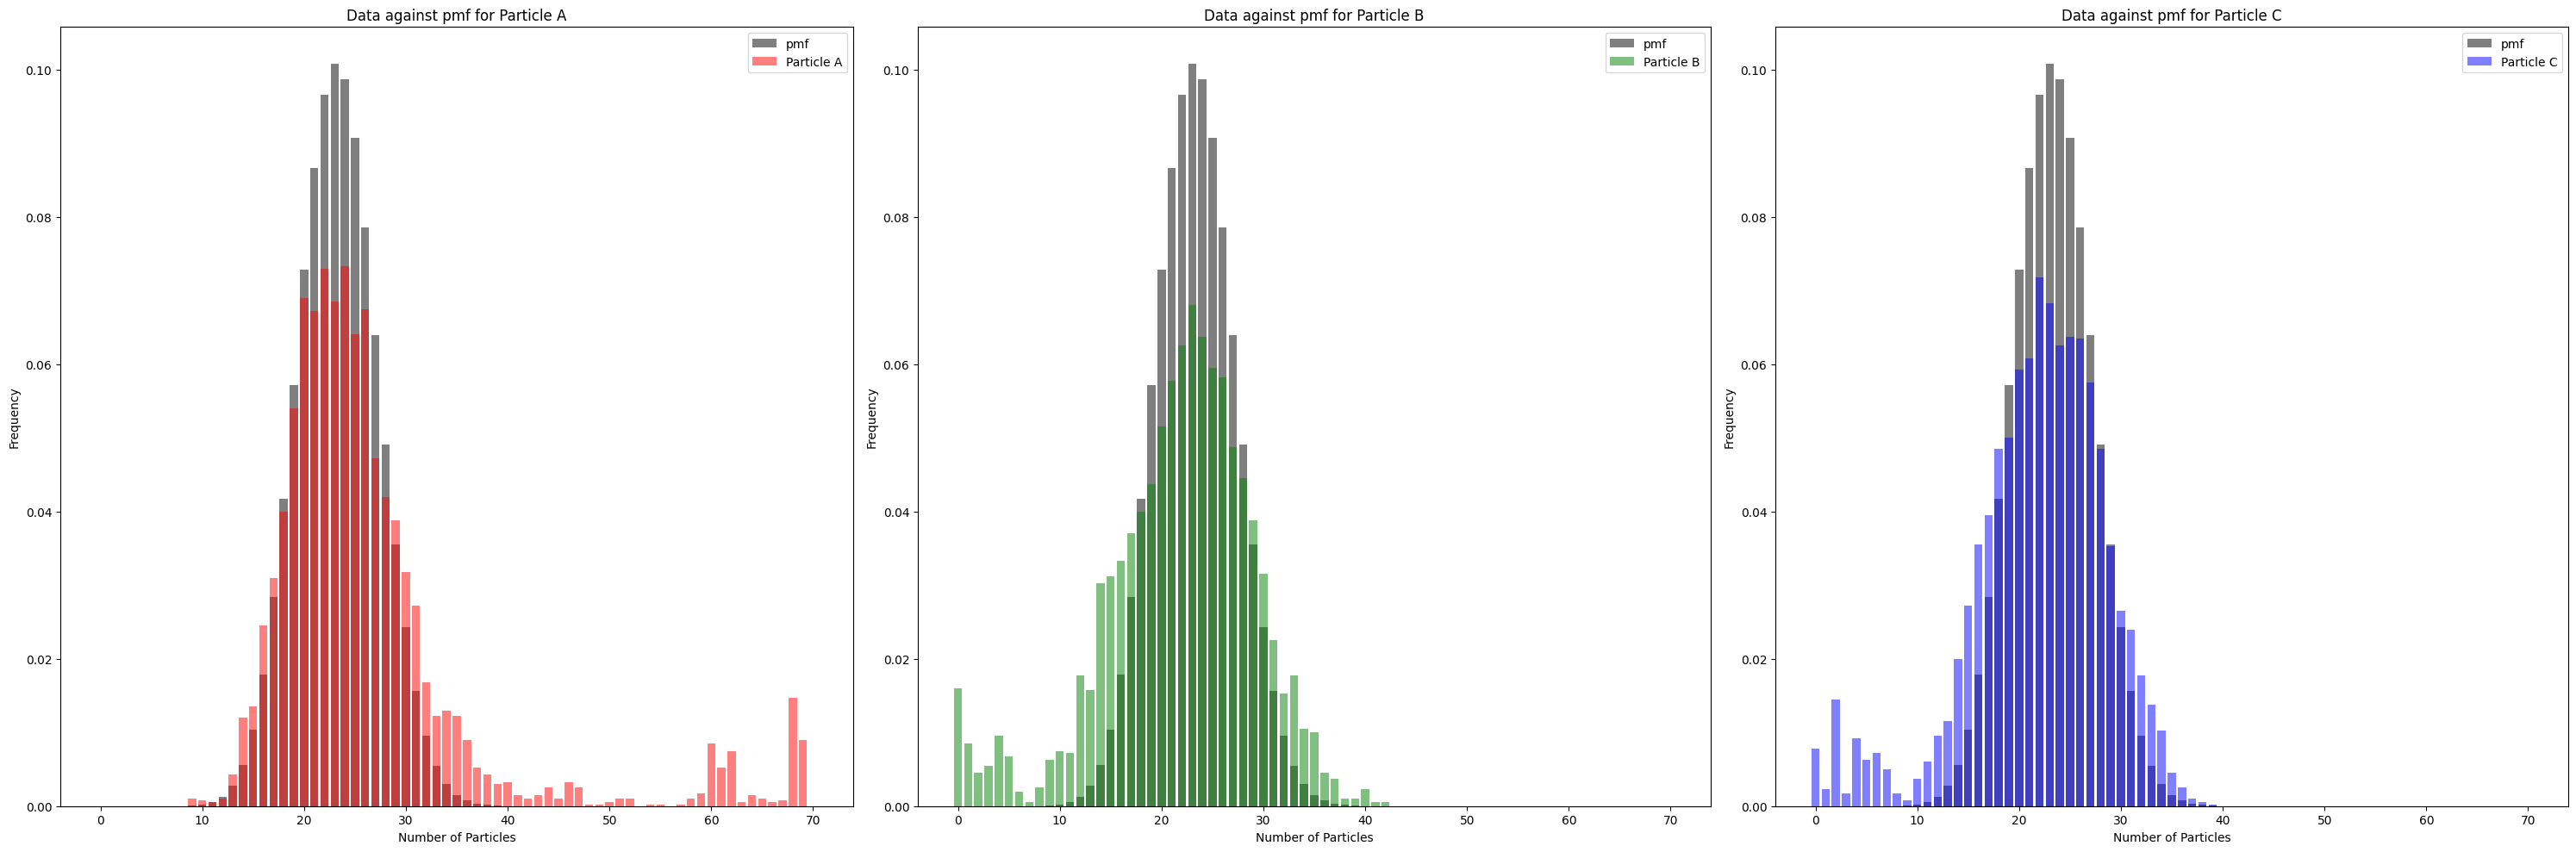

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

# setting the values
# of n and p
n = n_particles
p = 1/3
# defining the range of values we'll consider
r_values = list(range(n_particles + 1))
colour = ['r','g','b']
label = ['Particle A', 'Particle B', 'Particle C']

for k in range(3):

  ax = axes[k]

  ### BINOMIAL MODEL

  # obtaining the mean and variance
  mean, var = binom.stats(n, p)
  # list of pmf values
  dist = [binom.pmf(r, n, p) for r in r_values]
  ax.bar(r_values,dist,label='pmf',alpha=0.5,color='black')

  ### PARTICLE DATA
  N_k_t = [len(cs[i][cs[i]==k]) for i in range(len(cs))]
  N_k_count = Counter(N_k_t)
  N_k = [N_k_count[r]/(ts) for r in r_values]
  ax.bar(r_values,N_k,label=label[k],alpha=0.5,color=colour[k])

  ax.legend()
  ax.set_xlabel('Number of Particles')
  ax.set_ylabel('Frequency')
  ax.set_title('Data against pmf for '+label[k])


fig.tight_layout()
plt.show()

## Does concentration inequality hold?

In our extension, we wanted to find out how likely, say, species A is, from exceeding above the average $n/3$.

We can model each particle $X_1,\dots,X_n$ as a Bernoulli random variable where the sucess event is that particle $X_i$ is species A. Hence $\mathbb{P}(X_i=1)=1$ and $\mathbb{P}(X_i=0)=2/3$ where the failure event occurs when particle $X_i$ is species B or C.

We see that $N_A=\sum_{i=0}^{i=n}X_i$ then models the number of particles of species A in the box, so using Chernoff's inequality (derived in the pdf), we see that for $t\geq np$, we have

$$\mathbb{P}(N_A\geq t)\leq \left (\frac{enp}{t} \right )^te^{-np}$$

So for our situation with $p=1/3$, we can plot this formula against a histogram showing the number of time steps we had what number of particles of species A.




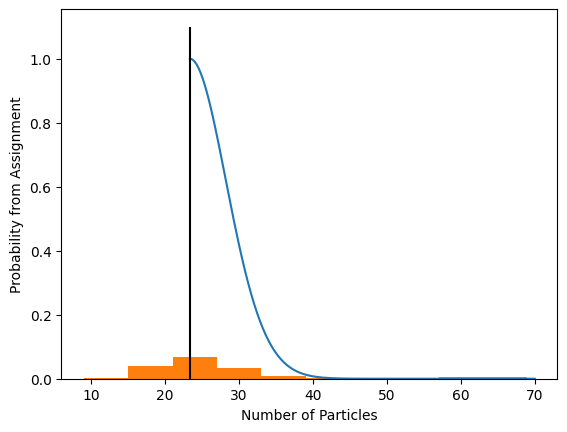

In [24]:
v = np.linspace(0, 2000, 1000)
p=1/3

# plot concentration inequality
t = np.linspace(n_particles/3,n_particles,1000)
p_N_A = np.power((np.exp(1)*n_particles*p/t),t)*np.exp(-n_particles*p)
plt.plot(t,p_N_A)

# plot distribution of how many red particles there are over time
N_a = []
for k in range(len(cs)):
  N_a.append(len(cs[k][cs[k]==0]))

plt.hist(N_a, density = True, label="")
plt.vlines(x =n_particles/3, ymin=0,ymax=1.1,color='black')
plt.xlabel("Number of Particles")
plt.ylabel("Probability from Assignment")

plt.show()

Less extreme example!

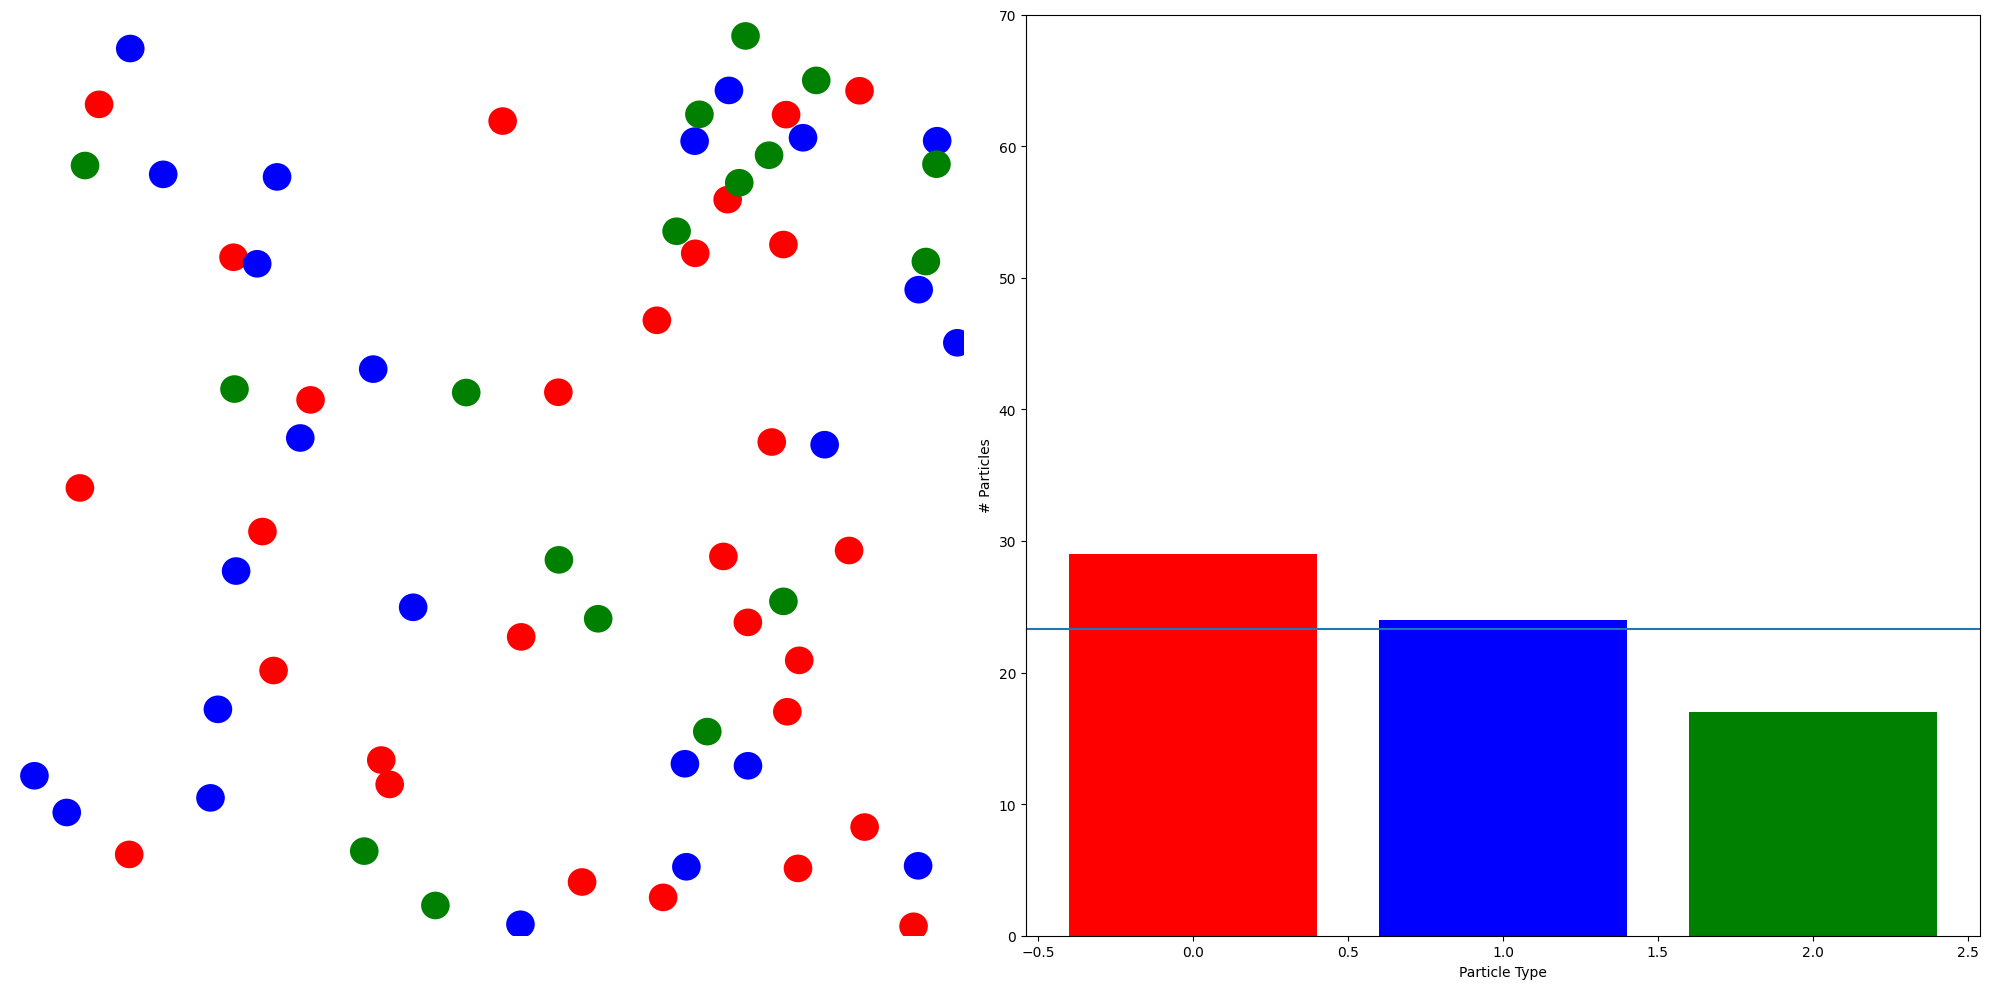

In [25]:
n_particles = 70

ts=2000

x = np.random.random((2,n_particles))
c = np.random.choice([0,1,2],size = n_particles,p=[1/3,1/3,1/3])
c[0] = 1
v = np.random.normal(30,500,size=(2,n_particles))

ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))
radius = 0.015

xs, vs, cs = motion(x, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

fig, axes = plt.subplots(1, 2, figsize=(20,10))

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani5.gif',writer='pillow',fps=30,dpi=100)

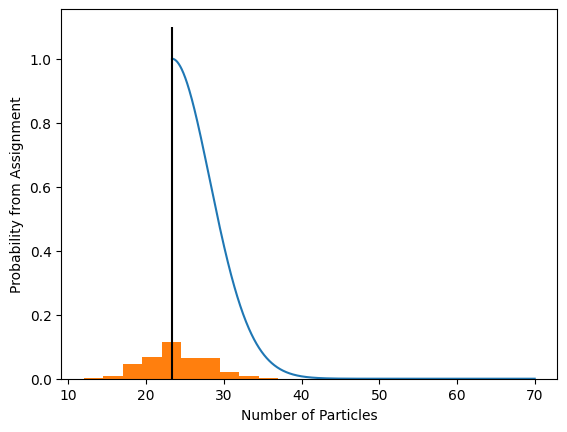

In [26]:
v = np.linspace(0, 2000, 1000)
p=1/3

# plot concentration inequality
t = np.linspace(n_particles/3,n_particles,1000)
p_N_A = np.power((np.exp(1)*n_particles*p/t),t)*np.exp(-n_particles*p)
plt.plot(t,p_N_A)

# plot distribution of how many red particles there are over time
N_a = []
for k in range(len(cs)):
  N_a.append(len(cs[k][cs[k]==0]))

plt.hist(N_a, density = True)
plt.vlines(x=n_particles/3, ymin=0,ymax=1.1,color='black')

plt.xlabel("Number of Particles")
plt.ylabel("Probability from Assignment")

plt.show()